In [1]:
!pip install -q ultralytics 
!pip install -q kaggle
!pip install -q seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patches, patheffects

import os
import json
import zipfile

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import cv2

from scipy.optimize import linear_sum_assignment
from typing import List, Tuple, Dict

%matplotlib inline

In [3]:
import sys
sys.path.append('../object_detection')  # adjust path as needed
from format_data import format_gt, format_model_predictions
from pred_gt_matching import match_predictions_to_gt_greedy
from classify_pred import process_single_class_single_image
from vis import visualize_detection_results, create_detection_summary_plot, plot_yolo_results, draw_im
from evaluator import ObjectDetectionEvaluator
from data_loader import collate_fn

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# # Set up Kaggle credentials from Colab secrets
# from google.colab import userdata
# kaggle_username = userdata.get('KAGGLE_USERNAME')
# kaggle_key = userdata.get('KAGGLE_KEY')

# Detect if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [6]:
if IN_COLAB:
    # Set up Kaggle credentials from Colab secrets
    from google.colab import userdata
    kaggle_username = userdata.get('KAGGLE_USERNAME')
    kaggle_key = userdata.get('KAGGLE_KEY')

    # Step 2: Create kaggle.json file with credentials
    kaggle_config = {
        "username": kaggle_username,
        "key": kaggle_key
    }
    
    # Create .kaggle directory and save credentials
    os.makedirs('/root/.kaggle', exist_ok=True)
    with open('/root/.kaggle/kaggle.json', 'w') as f:
        json.dump(kaggle_config, f)

    DATA_PATH = "/content/open-images-bus-trucks"
else:
    # Load Kaggle credentials from local file
    with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'r') as f:
        creds = json.load(f)
    kaggle_username = creds['username']
    kaggle_key = creds['key']

    DATA_PATH = "./data/open-images-bus-trucks"

# Set environment variables (optional, for some APIs that expect them)
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [7]:


# Step 3: Download the Open Images Bus Trucks dataset
# Replace with the actual dataset path from Kaggle
dataset_name = "sixhky/open-images-bus-trucks"  # Adjust this to the correct dataset name

print(f"Downloading dataset: {dataset_name}")
!kaggle datasets download -d {dataset_name}

Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks
License(s): unknown
 64%|█████████████████████████▍              | 233M/367M [00:00<00:00, 2.44GB/s]
100%|████████████████████████████████████████| 367M/367M [00:00<00:00, 2.41GB/s]


In [8]:
# Step 4: Extract the downloaded zip file
zip_filename = f"{dataset_name.split('/')[-1]}.zip"

print(f"Extracting {zip_filename} to {DATA_PATH}")
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(DATA_PATH)

# Step 5: List the contents of the extracted folder
print("\nDataset contents:")
for root, dirs, files in os.walk(DATA_PATH):
    level = root.replace(DATA_PATH, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:10]:  # Show first 10 files
        print(f"{subindent}{file}")
    if len(files) > 10:
        print(f"{subindent}... and {len(files) - 10} more files")

# Step 6: Clean up the zip file
os.remove(zip_filename)
print(f"\nCleaned up {zip_filename}")

print(f"\nDataset successfully downloaded and extracted to: {DATA_PATH}")

Extracting open-images-bus-trucks.zip to ./data/open-images-bus-trucks

Dataset contents:
open-images-bus-trucks/
  df.csv
  images/
    images/
      78bd6d45af1a2d6b.jpg
      d3b128296d6dc535.jpg
      1db4cdb2a64c92f8.jpg
      60251f63997c8035.jpg
      e9b9b22b48d77cba.jpg
      fbaaa97adfa57f28.jpg
      7e282f13b4896297.jpg
      bde6050232a4b331.jpg
      51a04c455db65f51.jpg
      31f2a0d0b0693c54.jpg
      ... and 15215 more files

Cleaned up open-images-bus-trucks.zip

Dataset successfully downloaded and extracted to: ./data/open-images-bus-trucks


In [9]:
# Reading the csv
IMAGE_ROOT = DATA_PATH + '/images'
DF_RAW = pd.read_csv(DATA_PATH + '/df.csv')
display(DF_RAW.head())
print(DF_RAW.shape)
class_names = DF_RAW['LabelName'].unique()
print(class_names)

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


(24062, 21)
['Bus' 'Truck']




Note that XMin, XMax, YMin, and YMax correspond to the ground truth of the bounding box of the image.


In [10]:
# create a custom dataset
class OpenImages(Dataset):
    def __init__(self, df, image_folder = IMAGE_ROOT):
        self.df = df
        self.unique_images = df['ImageID'].unique()
        self.root = image_folder

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, index):
        image_id = self.unique_images[index]
        image_path = f'{self.root}/images/{image_id}.jpg'
        image = cv2.imread(image_path, 1)  # converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        df = self.df.copy()
        df = df[df['ImageID'] == image_id]  # getting the row based on the index
        h, w, _ = image.shape
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w,h,w,h])).astype(np.uint16)
        classes = df['LabelName'].values.tolist()

        return image, boxes, classes, image_path

In [11]:
ds = OpenImages(DF_RAW)
len(ds)

15225

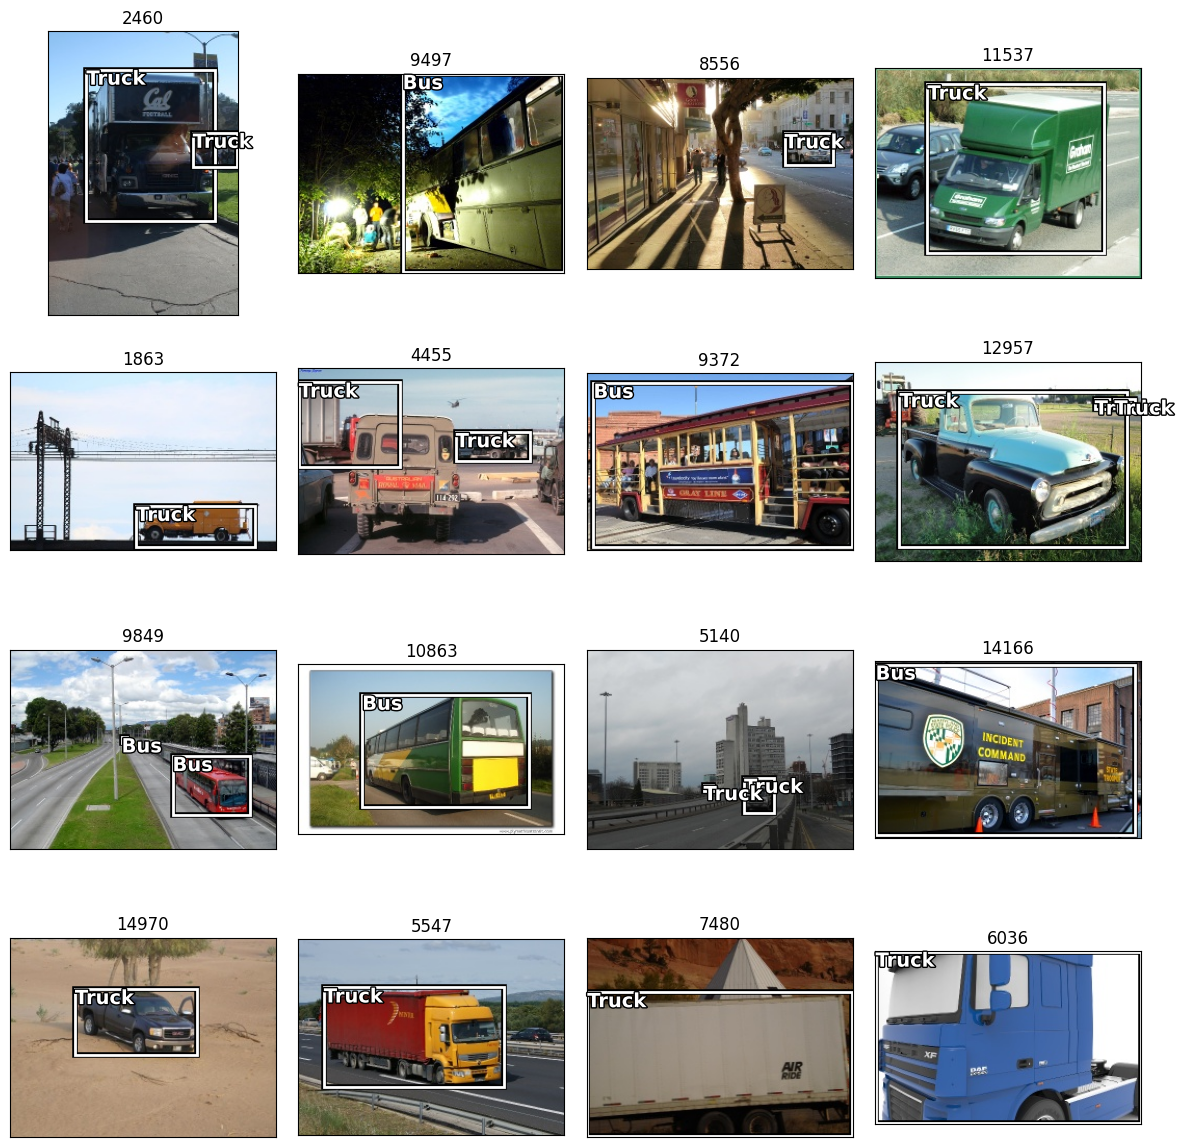

In [12]:
# Randomly select 16 indices
random_indices = np.random.choice(len(ds), 16, replace=False)

# Create a figure with 4x4 subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Iterate through the random indices and display the images
for i, idx in enumerate(random_indices):
    im, bbs, clss, _ = ds[idx]
    draw_im(im, bbs=bbs, classes=clss, ax=axes[i], figsize=(3,3), title=idx)

plt.tight_layout()
plt.show()

Found 146 images containing both buses and trucks.


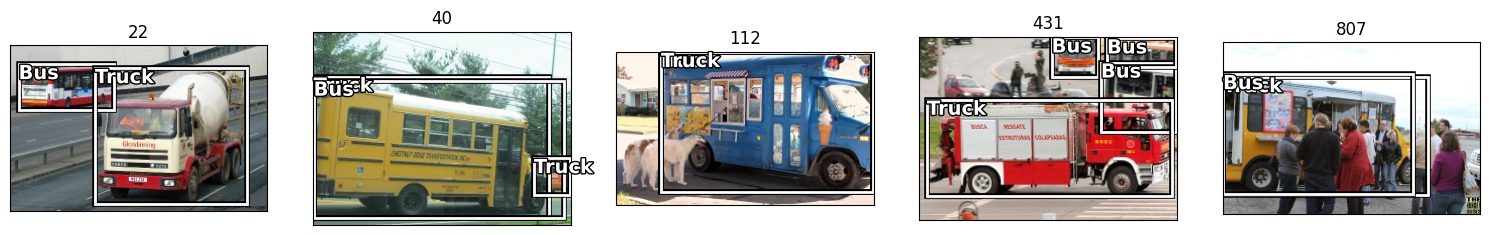

In [13]:
# Find ImageIDs that have both 'Bus' and 'Truck' labels
bus_truck_image_ids = DF_RAW.groupby('ImageID')['LabelName'].apply(lambda x: set(x) == {'Bus', 'Truck'})
bus_truck_image_ids = bus_truck_image_ids[bus_truck_image_ids].index.tolist()

print(f"Found {len(bus_truck_image_ids)} images containing both buses and trucks.")

# Display the first few images (e.g., 5 images)
num_images_to_show = min(5, len(bus_truck_image_ids))

if num_images_to_show > 0:
    fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))
    if num_images_to_show == 1:
        axes = [axes] # Make it iterable if there's only one subplot

    for i in range(num_images_to_show):
        image_id = bus_truck_image_ids[i]
        # Find the index of this image_id in the unique_images list of the dataset
        idx = np.where(ds.unique_images == image_id)[0][0]
        im, bbs, clss, _ = ds[idx]
        draw_im(im, bbs=bbs, classes=clss, ax=axes[i], title=idx)

    plt.tight_layout()
    plt.show()
else:
    print("No images found with both buses and trucks.")

Next, we'll select an image from your dataset and run the model on it. We'll then visualize the results with the detected bounding boxes and labels.

# process 1 image (demo)

In [14]:
target_classes = ['bus', 'truck']
evaluator = ObjectDetectionEvaluator(target_classes)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)

Using cache found in /home/amir/.cache/torch/hub/ultralytics_yolov5_master
/home/amir/.cache/torch/hub/ultralytics_yolov5_master/utils/general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
YOLOv5 🚀 2025-7-23 Python-3.12.3 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [15]:
%matplotlib inline

📦 Detected YOLO-style output format
   🔍 Found 17 raw detections
   ✅ Kept 1 predictions after confidence filtering
[]


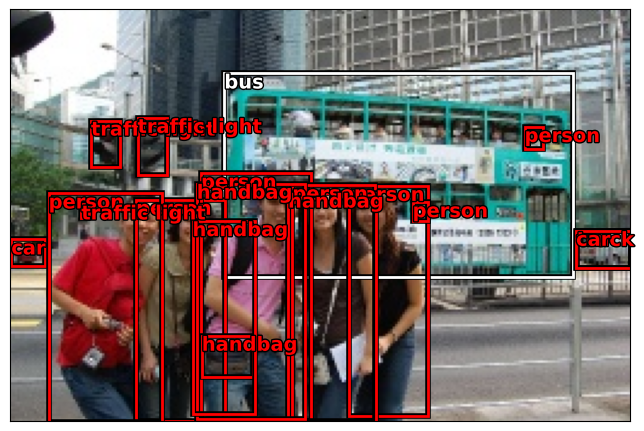

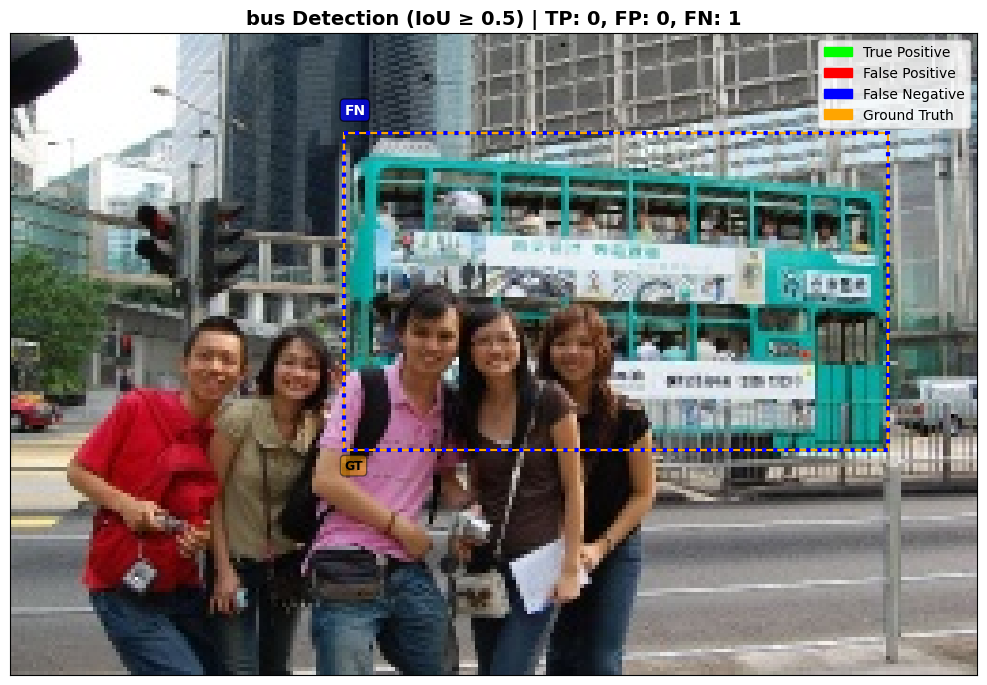

[{'bbox': [233.4917755126953, 91.01224517822266, 256.0, 106.32723236083984], 'score': 0.3689504563808441, 'class': 1, 'class_name': 'truck'}]


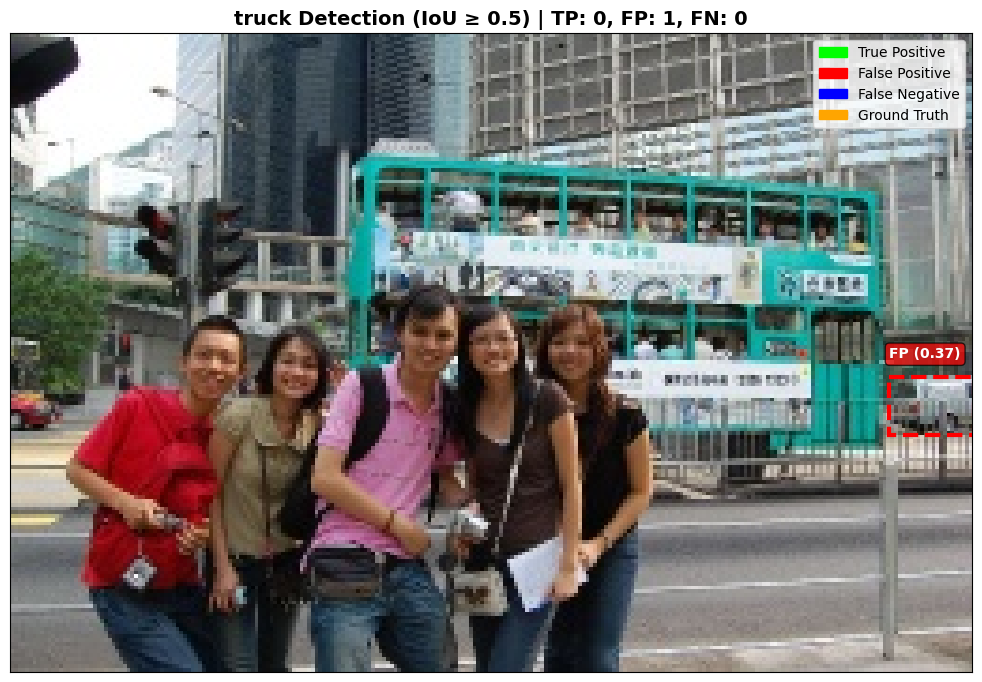


Results for class: bus
TP: 0
FP: 0
FN: 1

Results for class: truck
TP: 0
FP: 1
FN: 0


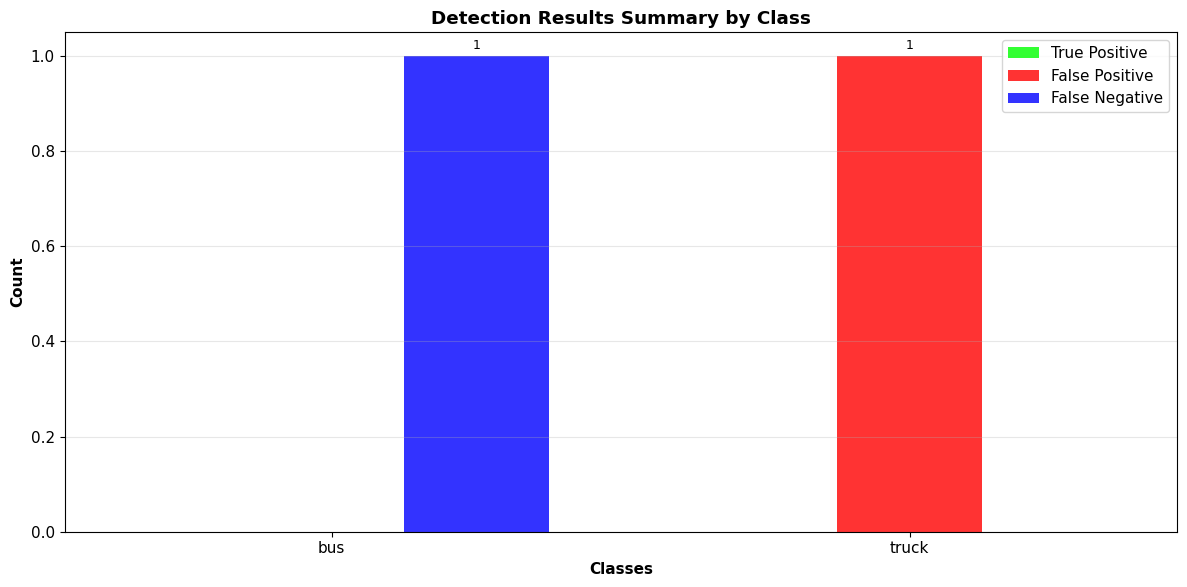

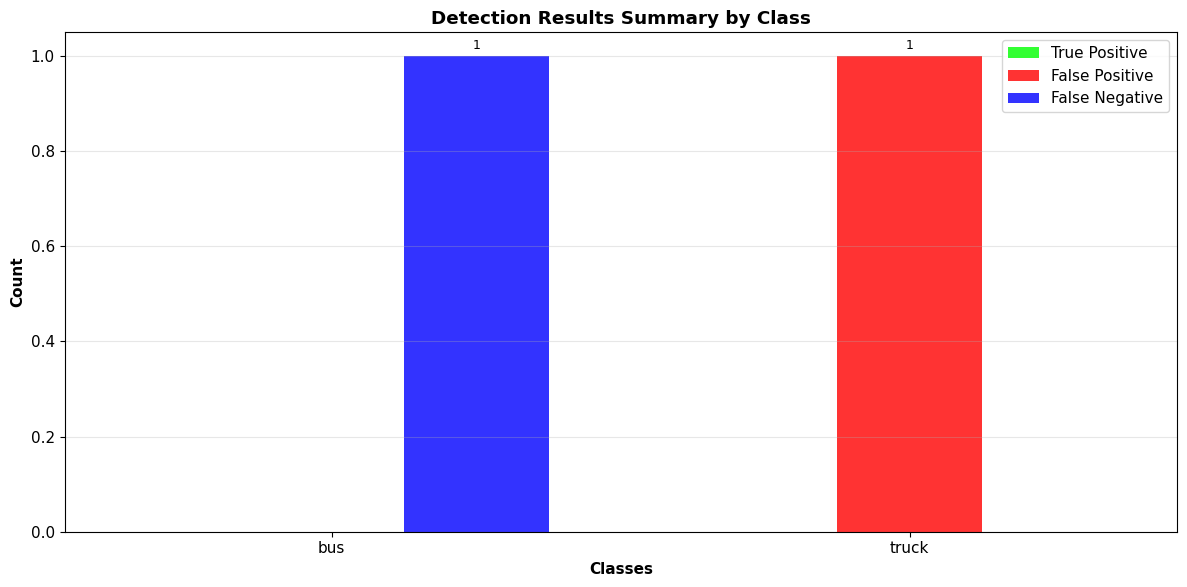

In [16]:
# Select an image from your dataset (e.g., the first image)
# We'll use image 22 from the dataset for demonstration, as it contains both Bus and Truck
image, bbs, clss, image_path = ds[0]

# run model
results = model(image)

# arrange data
ground_truths_all = format_gt([bbs], [clss], target_classes)
predictions_all = format_model_predictions(results, class_names)

# temp - for one image
predictions_all = predictions_all['image0.jpg']
ground_truths_all = ground_truths_all['image0.jpg']

# draw all detections and gt boxes
plot_yolo_results(results, image, model.names, ground_truths_all)

# Iterate through each target class and evaluate
eval_results = {}
for class_id, class_name in enumerate(target_classes):
    # Filter predictions for the current class
    class_predictions = [p for p in predictions_all if p['class'] == class_id]
    print(class_predictions)

    # Filter ground truths for the current class
    class_ground_truths = [gt for gt in ground_truths_all if gt['class'] == class_id]
      
    # pred_boxes = np.array([p['bbox'] for p in class_predictions])
    # gt_boxes = np.array([gt['bbox'] for gt in class_ground_truths])
    
    # iou_matrix = calculate_iou(pred_boxes, gt_boxes)
    iou_matrix = evaluator.calculate_iou_matrix_single_class(class_predictions, class_ground_truths, class_id)

    # Process this single class in this single image
    results_per_class = process_single_class_single_image(
        predictions=class_predictions, # Pass the filtered predictions
        ground_truths=class_ground_truths, # Pass the filtered ground truths
        target_class=class_id,
        iou_matrix=iou_matrix, # Pass the class-specific IoU matrix
        iou_threshold=0.5,
        use_hungarian=True # Use Hungarian matching
    )

    # Visualize the results for the current class
    # We pass the filtered ground truths for visualization
    fig = visualize_detection_results(
        image=image,
        results=results_per_class,
        ground_truths=class_ground_truths,
        class_name=class_name,
        iou_threshold=0.5,
        show_confidence=True
    )
    plt.show()

    eval_results[class_name] = results_per_class

for i, class_name in enumerate(target_classes):
    print(f"\nResults for class: {class_name}")
    print(f"TP: {eval_results[class_name]['num_tp']}")
    print(f"FP: {eval_results[class_name]['num_fp']}")
    print(f"FN: {eval_results[class_name]['num_fn']}")

create_detection_summary_plot(eval_results, target_classes)

# test evaluator

In [17]:
# import torch.nn.functional as F

# def stack_images_with_padding(images):
#     """
#     Stack images by padding them to the same size (preserves aspect ratio).

#     Args:
#         images: List of image tensors with potentially different sizes

#     Returns:
#         4D tensor of stacked images
#     """
#     # Find maximum dimensions
#     max_h = max(img.shape[-2] for img in images)
#     max_w = max(img.shape[-1] for img in images)

#     padded_images = []

#     for img in images:
#         h, w = img.shape[-2:]

#         # Calculate padding
#         pad_h = max_h - h
#         pad_w = max_w - w

#         # Pad image (left, right, top, bottom)
#         padded_img = F.pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
#         padded_images.append(padded_img)

#     return torch.stack(padded_images, dim=0)

In [18]:

# dataset
dataset = OpenImages(DF_RAW)

# Create the DataLoader
batch_size = 4

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=4,  # Add multiprocessing for faster loading
    pin_memory=True  # Faster GPU transfer
)

print(f"DataLoader created with batch size: {batch_size}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

DataLoader created with batch size: 4
Using device: cpu


In [20]:
evaluator = ObjectDetectionEvaluator(class_names)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)
model.eval()

# for batch_idx, batch in enumerate(dataloader):

# Set to True to process only the first few batches for testing
process_first_batches = True
num_batches_to_process = 20

# Loop through the DataLoader
for batch_idx, batch in enumerate(dataloader):
    if process_first_batches and batch_idx >= num_batches_to_process:
        print(f"Processed {num_batches_to_process} batches for testing.")
        break

    images, gt_bboxes, gt_classes, images_path = batch

    with torch.no_grad():
        # Batch inference
        res = model(images_path)
    
    # Format predictions for current image
    image_predictions = format_model_predictions(res, class_names)
    ground_truths = format_gt(gt_bboxes, gt_classes, class_names, res.files)
    
    # Process each image in the batch
    for inx, image_id in enumerate(res.files):
        # image_id = images_path[i]

        # Evaluate each class
        for class_id in range(0, len(class_names)):
            iou_matrix = evaluator.calculate_iou_matrix_single_class(
                predictions=image_predictions[image_id],
                ground_truths=ground_truths[image_id],
                class_id=class_id
            )

            results = process_single_class_single_image(
                predictions=image_predictions[image_id],
                ground_truths=ground_truths[image_id],
                target_class=class_id,
                iou_matrix=iou_matrix,
                iou_threshold=0.5,
                use_hungarian=False
            )

            evaluator.store_results(image_id, class_id, results)

    if batch_idx % 100 == 0:
        print(f"Processed {batch_idx + 1} batches...")


Using cache found in /home/amir/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-7-23 Python-3.12.3 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


📦 Detected YOLO-style output format
   🔍 Found 17 raw detections
   ✅ Kept 1 predictions after confidence filtering
   🔍 Found 7 raw detections
   ✅ Kept 3 predictions after confidence filtering
   🔍 Found 4 raw detections
   ✅ Kept 2 predictions after confidence filtering
   🔍 Found 8 raw detections
   ✅ Kept 0 predictions after confidence filtering
Processed 1 batches...
📦 Detected YOLO-style output format
   🔍 Found 3 raw detections
   ✅ Kept 1 predictions after confidence filtering
   🔍 Found 3 raw detections
   ✅ Kept 1 predictions after confidence filtering
   🔍 Found 10 raw detections
   ✅ Kept 3 predictions after confidence filtering
   🔍 Found 10 raw detections
   ✅ Kept 1 predictions after confidence filtering
📦 Detected YOLO-style output format
   🔍 Found 1 raw detections
   ✅ Kept 1 predictions after confidence filtering
   🔍 Found 1 raw detections
   ✅ Kept 1 predictions after confidence filtering
   🔍 Found 3 raw detections
   ✅ Kept 0 predictions after confidence filteri

In [21]:
evaluator.print_evaluation_summary()

Object Detection Evaluation Summary
Total images evaluated: 80
Total classes: 2

Class: Bus
  Average Precision (AP): 0.624
  Ground Truth objects: 65
  True Positives: 42
  False Positives: 7
  False Negatives: 23

Class: Truck
  Average Precision (AP): 0.475
  Ground Truth objects: 65
  True Positives: 37
  False Positives: 26
  False Negatives: 28

Mean Average Precision (mAP): 0.549


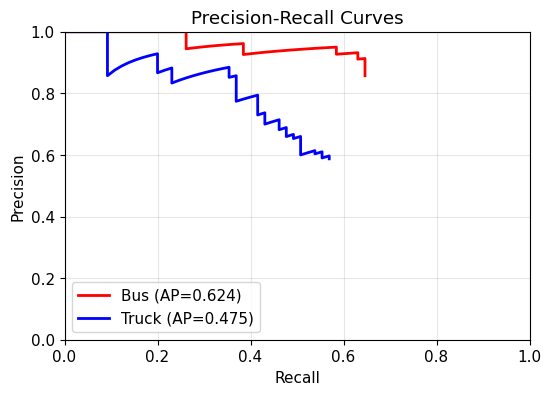

In [22]:
evaluator.plot_precision_recall_curves()